Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [5]:
#Set up a dateframes to put the results in

import pandas as pd
results_df = pd.DataFrame(
    index = np.arange(0, 10001, 500),
    columns = ['loss', 'train accuracy', 'validation accuracy', 'test accuracy']
)
results_df.iloc[0:7]

,loss,train accuracy,validation accuracy,test accuracy
0,NaN,NaN,NaN,NaN
500,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN
1500,NaN,NaN,NaN,NaN
2000,NaN,NaN,NaN,NaN
2500,NaN,NaN,NaN,NaN
3000,NaN,NaN,NaN,NaN


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### 3.1.1 Logistic Regression Model (SGD)

In [6]:
batch_size = 128
l2reg_beta = 0.0011

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                        + l2reg_beta*tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
results_df.iloc[0:7]

Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,23.2696,8.59375,8.15,7.18
500,2.66467,78.9062,76.34,84.28
1000,1.54455,80.4688,78.44,85.85
1500,1.26835,79.6875,80.16,87.68
2000,0.869962,78.125,80.86,87.71
2500,1.0026,78.9062,81.7,88.69
3000,0.662222,84.375,82.33,89.08


Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['step', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


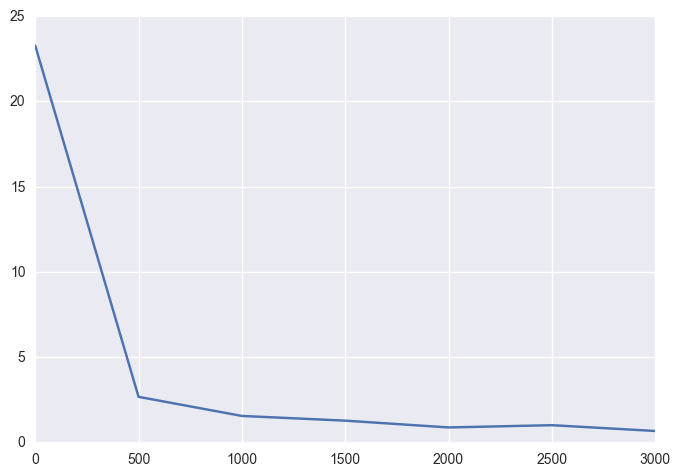

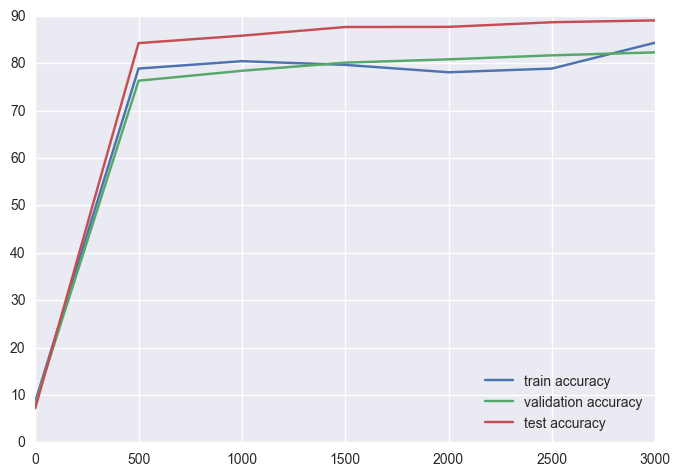

In [8]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

results_df.iloc[0:7]['loss'].plot()
results_df.iloc[0:7][['train accuracy', 'validation accuracy', 'test accuracy']].plot()

### 3.1.2 Neural Network Model

In [9]:
num_hnodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
  h_biases = tf.Variable(tf.zeros([num_hnodes]))
  weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
  logits = tf.matmul(h_layer, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                        + l2reg_beta*tf.nn.l2_loss(h_weights)
                        + l2reg_beta*tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                   tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                 weights) +   biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                  tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                               weights) +   biases)

Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,659.59,14.8438,27.51,29.44
500,199.572,84.375,80.44,87.23
1000,113.609,80.4688,81.69,88.18
1500,65.4743,85.9375,83.03,89.73
2000,37.214,90.625,85.34,92.19
2500,21.7385,84.375,86.91,93
3000,12.6814,87.5,87.18,93.38


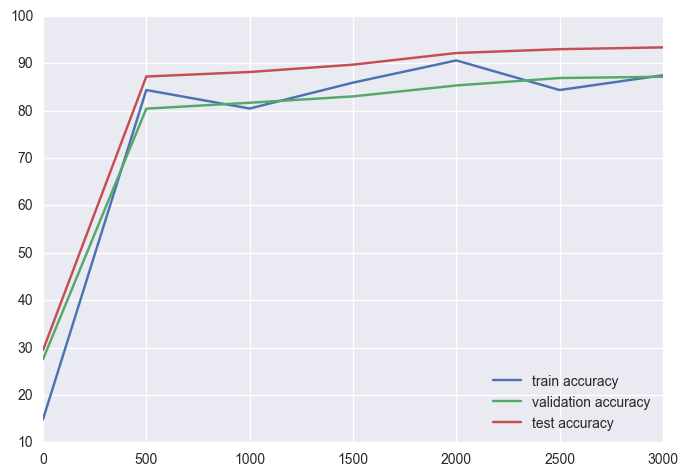

In [10]:
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
display(results_df.iloc[0:7])
results_df.iloc[0:7][['train accuracy', 'validation accuracy', 'test accuracy']].plot()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [11]:
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
  h_biases = tf.Variable(tf.zeros([num_hnodes]))
  weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
  logits = tf.matmul(h_layer, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                        + l2reg_beta*tf.nn.l2_loss(h_weights)
                        + l2reg_beta*tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                   tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                 weights) +   biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                  tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                               weights) +   biases)

Training set (200000, 784) (200000, 10)
Small training set (641, 784) (641, 10)
Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,646.251,8.59375,29.15,30.28
500,199.744,100,75.33,82
1000,115.224,100,75.19,81.96
1500,66.4684,100,75.08,81.91
2000,38.3432,100,75.06,81.91
2500,22.119,100,75.29,81.98
3000,12.7613,100,75.85,82.29


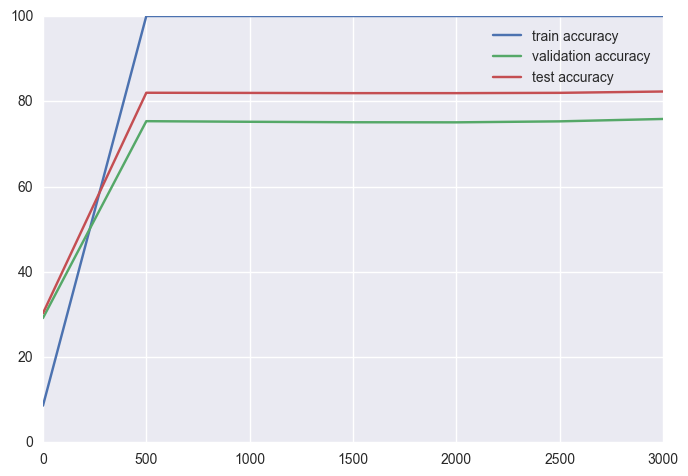

In [12]:
num_batches = 5
small_train_dataset = train_dataset[:(num_batches*batch_size+1),:] 
small_train_labels = train_labels[:(num_batches*batch_size+1),:]

print('Training set', train_dataset.shape, train_labels.shape)
print('Small training set', small_train_dataset.shape, small_train_labels.shape)

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = small_train_dataset[offset:(offset + batch_size), :]
    batch_labels = small_train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
display(results_df.iloc[0:7])
results_df.iloc[0:7][['train accuracy', 'validation accuracy', 'test accuracy']].plot()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [13]:
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  keep_prob = tf.placeholder("float")
  
  # Variables.
  h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
  h_biases = tf.Variable(tf.zeros([num_hnodes]))
  weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
  h_layer_drop = tf.nn.dropout(h_layer, keep_prob)  

  logits = tf.matmul(h_layer_drop, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                        + l2reg_beta*tf.nn.l2_loss(h_weights)
                        + l2reg_beta*tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                   tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                 weights) +   biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                  tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                               weights) +   biases)

Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,1136.08,12.5,32.14,34.85
500,225.558,95.3125,78.33,85.21
1000,128.819,98.4375,79.07,85.64
1500,74.972,99.2188,78.05,84.93
2000,43.4772,98.4375,78.76,85.39
2500,25.1516,100,78.4,85.32
3000,14.5727,99.2188,79.11,86.04


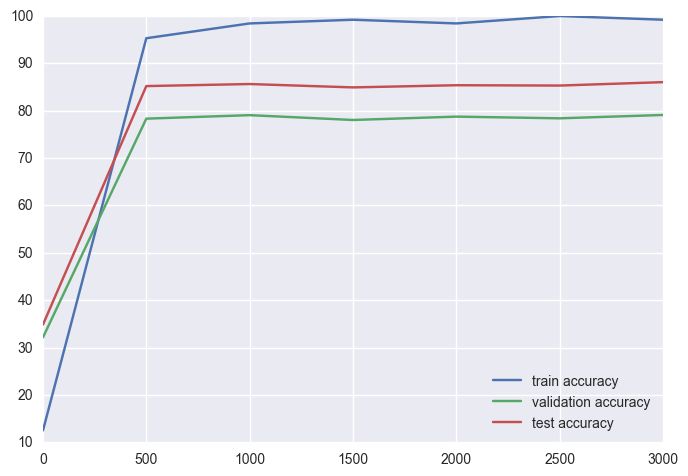

In [14]:
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = small_train_dataset[offset:(offset + batch_size), :]
    batch_labels = small_train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.2}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
display(results_df.iloc[0:7])
results_df.iloc[0:7][['train accuracy', 'validation accuracy', 'test accuracy']].plot()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,4.63797,6.25,10,10
500,0.544073,85.1562,83.81,90.79
1000,0.560796,85.9375,85.41,91.75
1500,0.66026,85.9375,86.13,92.19
2000,0.469107,85.9375,86.7,92.53
2500,0.683953,82.8125,87.19,93.09
3000,0.467242,86.7188,87.73,93.32
3500,0.521221,85.9375,88.06,93.4
4000,0.509438,84.375,88.11,93.48
4500,0.3457,92.1875,88.39,93.62


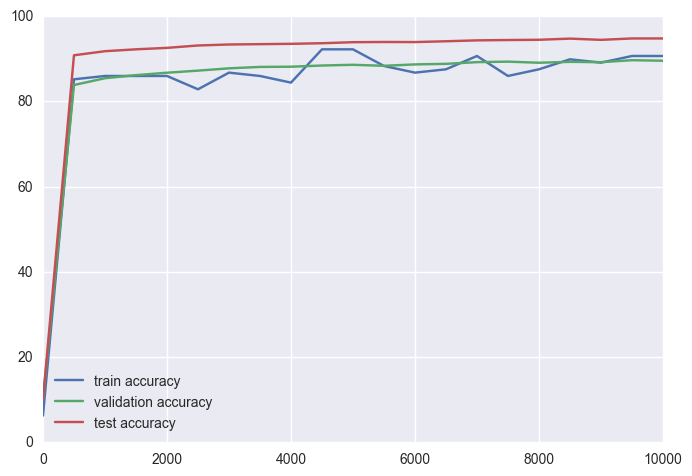

In [15]:
num_steps = 10001#3001
l2reg_beta = 0.00001#0.0011

keep_prob = 0.5

num_h1nodes = 2048
num_h2nodes = 512

weights1_stdev = 1.0/image_size/keep_prob
weights2_stdev = 1.0/sqrt(num_h1nodes)/keep_prob
weights_stdev = 1.0/sqrt(num_h2nodes)/keep_prob

initial_learning_rate = 0.5#0.1
decay_steps = 1000
decay_rate = 0.98#0.8

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  h1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_h1nodes], 0.0, weights1_stdev))
  h1_biases = tf.Variable(tf.zeros([num_h1nodes]))
  h2_weights = tf.Variable(tf.truncated_normal([num_h1nodes, num_h2nodes], 0.0, weights2_stdev))
  h2_biases = tf.Variable(tf.zeros([num_h2nodes]))
  weights = tf.Variable(tf.truncated_normal([num_h2nodes, num_labels], 0.0, weights_stdev))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  h1_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h1_weights) + h1_biases)
  h1_layer_drop = tf.nn.dropout(h1_layer, keep_prob)  
  h2_layer = tf.nn.relu(tf.matmul(h1_layer_drop, h2_weights) + h2_biases)
  h2_layer_drop = tf.nn.dropout(h2_layer, keep_prob)  

  logits = tf.matmul(h2_layer_drop, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                        + l2reg_beta*tf.nn.l2_loss(h1_weights)
                        + l2reg_beta*tf.nn.l2_loss(h2_weights)
                        + l2reg_beta*tf.nn.l2_loss(weights))
  
  # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay( initial_learning_rate, global_step, decay_steps, decay_rate,
                                              staircase=True )
    
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                   tf.matmul(tf.nn.relu(
                                   tf.matmul(tf_valid_dataset, h1_weights) + h1_biases),
                                                               h2_weights) + h2_biases),
                                                                  weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                  tf.matmul(tf.nn.relu(
                                  tf.matmul(tf_test_dataset, h1_weights) + h1_biases),
                                                             h2_weights) + h2_biases),
                                                                weights) + biases)
    
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
  global_step+=1

display(results_df)
results_df[['train accuracy', 'validation accuracy', 'test accuracy']].plot()